In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas_datareader.data as pdr

import datetime as dt
import yfinance as yf

import random
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Flatten, Conv2D, MaxPool2D, Input
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.wrappers.scikit_learn import KerasRegressor


import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

from tensorflow.keras import backend as K

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

# Bagging
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

# Boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

from pandas.plotting import scatter_matrix
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
plt.style.use('ggplot')

mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['grid.alpha'] = 0.25

mpl.rcParams['legend.fontsize'] = 10

In [4]:
DATADIR = Path.cwd()

filepath = os.path.join(DATADIR, 'data_with_covid.csv')

D = pd.read_csv(filepath, index_col = [0], infer_datetime_format = True)
D.columns = (x.lower() for x in D.columns)

TRAIN_TEST_CUTOFF = int((len(D) * 0.8))

train_set = D.iloc[:TRAIN_TEST_CUTOFF, :]
test_set = D.iloc[TRAIN_TEST_CUTOFF:, :]

scaler = MinMaxScaler(feature_range = (-1, 1))
train_set_scaled = scaler.fit_transform(train_set)
test_set_scaled = scaler.transform(test_set)

In [5]:
def build_model(u, ep, v):
    X_train = []
    y_train = []

    for i in range(len(train_set_scaled)):
        X_train.append(train_set_scaled[i, 1:])
        y_train.append(train_set_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    print(X_train.shape, y_train.shape)

    def biLSTM(u):
        model = Sequential()
        model.add(Bidirectional(LSTM(units = u, return_sequences = True), input_shape = (X_train.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(units = u, return_sequences = True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(units = u, return_sequences = True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(units = u)))
        model.add(Dense(units = 1))
        return model
    
    model = biLSTM(u)

    model.compile(optimizer="adam", loss="mae", metrics=["mse"])

    model.summary()
    
    model.fit(X_train, y_train, epochs = ep, batch_size = 10, verbose=v)
    
    predict_train = model.predict(X_train, batch_size=10, verbose=v)
    
    X_test = []
    y_test = []

    for i in range(len(test_set_scaled)):
        X_test.append(test_set_scaled[i, 1:])
        y_test.append(test_set_scaled[i, 0])

    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    y_test = np.reshape(y_test, (-1, 1))
    y_train=np.reshape(y_train,(-1,1))
    
    predicted_stock_price=model.predict(X_test)
    
    def print_error(trainY, testY, train_predict, test_predict):    
        ### Error of predictions
        train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
        test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
        ### Print RMSE
        print('Train RMSE: %.3f RMSE' % (train_rmse))
        print('Test RMSE: %.3f RMSE' % (test_rmse))
    
    print_error(y_train, y_test, predict_train, predicted_stock_price)
    
    pred_array = np.repeat(predicted_stock_price, len(D.columns), axis = -1)
    
    pred = scaler.inverse_transform(pred_array)[:,0]
    
    graph_test = pd.DataFrame(test_set.iloc[:,0])
    graph_test['pred'] = pred

    
    fig, ax = plt.subplots(figsize = (12,10))
    graph_test['gold'].plot(linestyle = '--')
    graph_test['pred'].plot(linestyle = '-')
    ax.set_title('Bi-LSTM')
    ax.legend()



(1800, 33, 1) (1800,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 33, 66)           9240      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 33, 66)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 33, 66)           26400     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 33, 66)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 33, 66)           26400     
 nal)                                                            
                                  

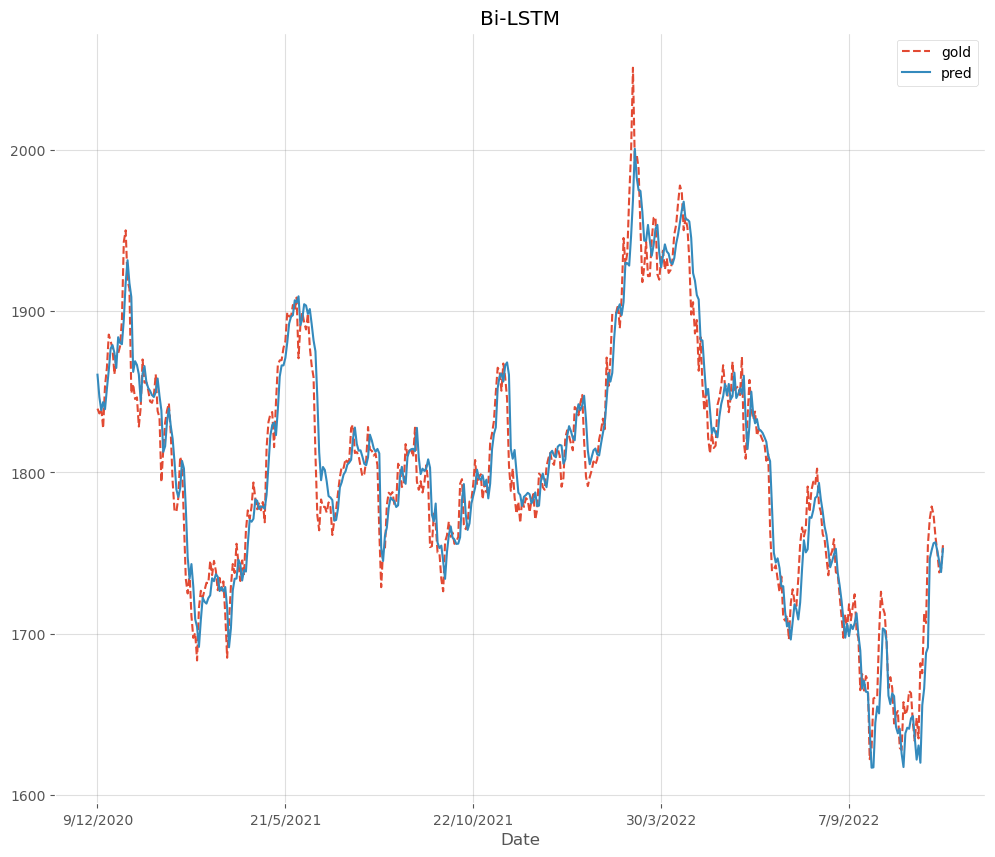

In [6]:
BLSTM_1 = build_model(33, 50, 0)

(1800, 33, 1) (1800,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 33, 66)           9240      
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 33, 66)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 33, 66)           26400     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 33, 66)            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 33, 66)           26400     
 nal)                                                            
                                

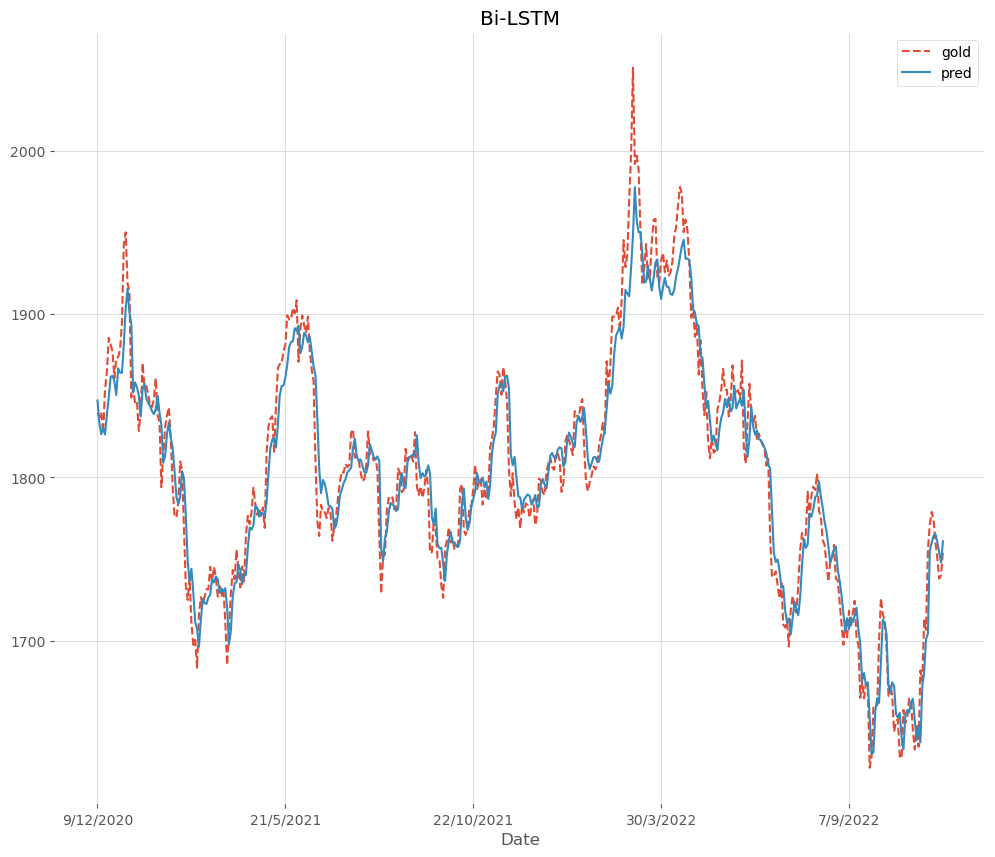

In [7]:
BLSTM_2 = build_model(33, 50, 0)

(1800, 33, 1) (1800,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 33, 66)           9240      
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 33, 66)            0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 33, 66)           26400     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 33, 66)            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 33, 66)           26400     
 onal)                                                           
                                

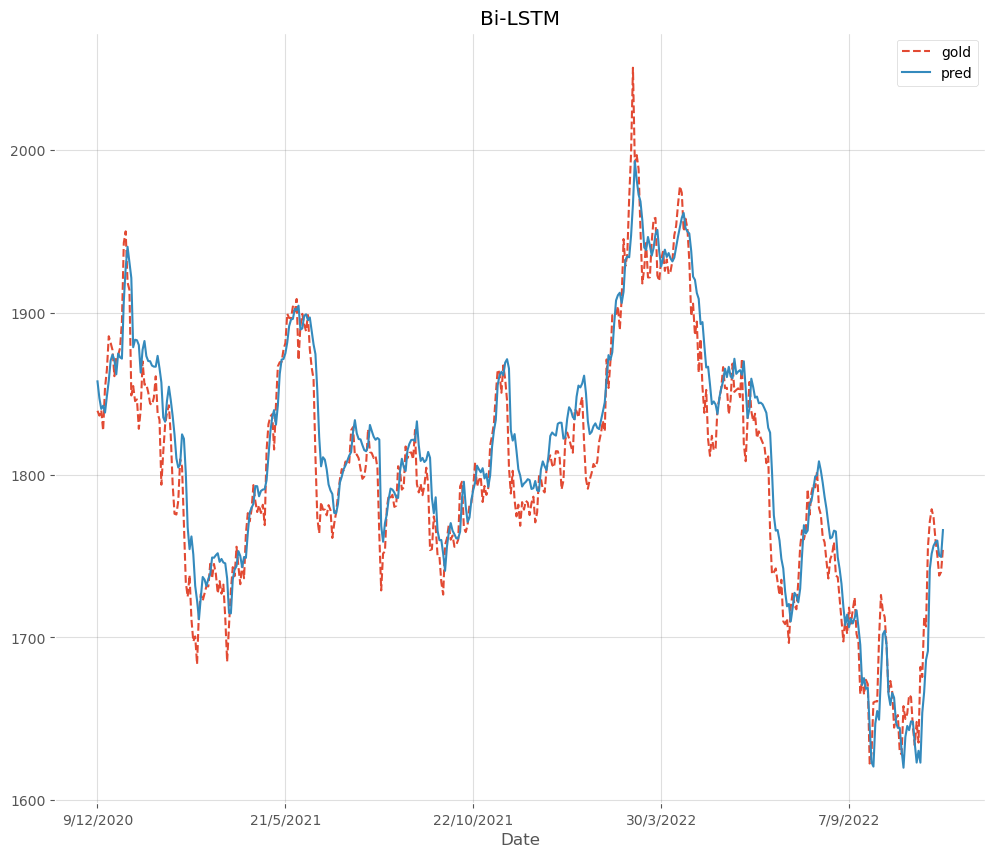

In [8]:
BLSTM_3 = build_model(33, 50, 0)

(1800, 33, 1) (1800,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 33, 66)           9240      
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 33, 66)            0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 33, 66)           26400     
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 33, 66)            0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 33, 66)           26400     
 onal)                                                           
                                

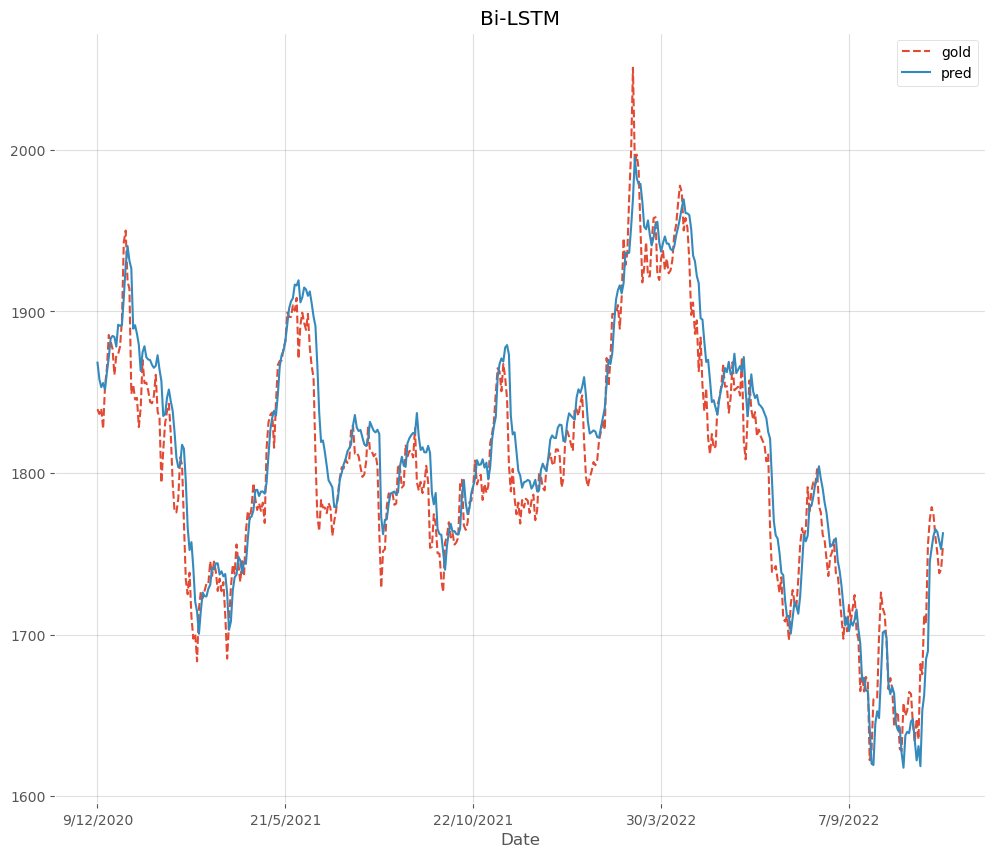

In [9]:
BLSTM_4 = build_model(33, 50, 0)

(1800, 33, 1) (1800,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirecti  (None, 33, 66)           9240      
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 33, 66)            0         
                                                                 
 bidirectional_17 (Bidirecti  (None, 33, 66)           26400     
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 33, 66)            0         
                                                                 
 bidirectional_18 (Bidirecti  (None, 33, 66)           26400     
 onal)                                                           
                                

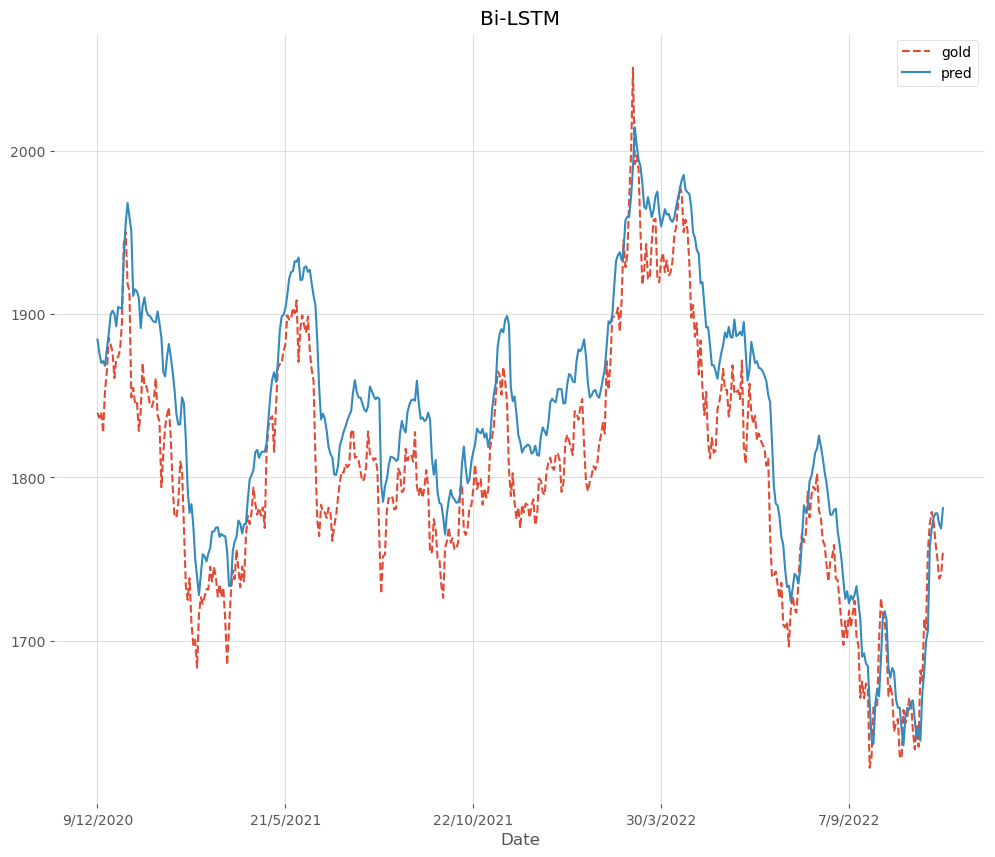

In [10]:
BLSTM_5 = build_model(33, 50, 0)

(1800, 33, 1) (1800,)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_20 (Bidirecti  (None, 33, 66)           9240      
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 33, 66)            0         
                                                                 
 bidirectional_21 (Bidirecti  (None, 33, 66)           26400     
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 33, 66)            0         
                                                                 
 bidirectional_22 (Bidirecti  (None, 33, 66)           26400     
 onal)                                                           
                                

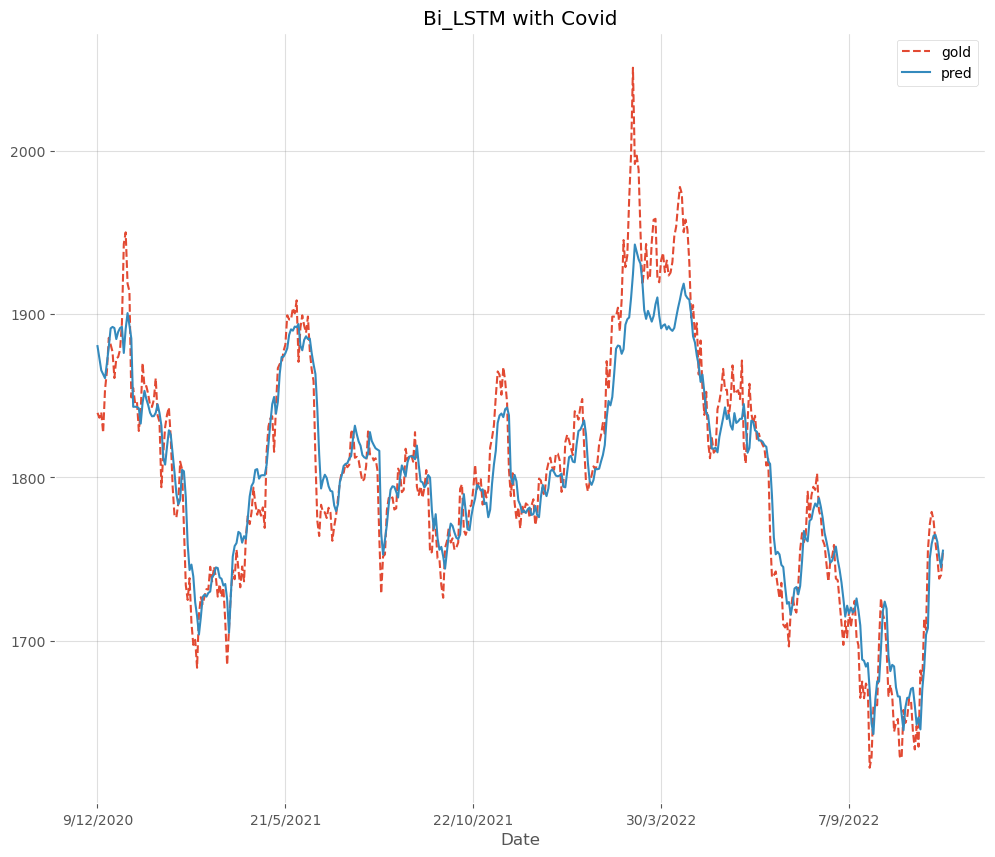

In [11]:
X_train = []
y_train = []

for i in range(len(train_set_scaled)):
    X_train.append(train_set_scaled[i, 1:])
    y_train.append(train_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape, y_train.shape)

def biLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 33, return_sequences = True), input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units = 33, return_sequences = True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units = 33, return_sequences = True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units = 33)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    return model

model = biLSTM()

model.compile(optimizer="adam", loss="mae", metrics=["mse"])

model.summary()

model.fit(X_train, y_train, epochs = 50, batch_size = 10, verbose=0)

predict_train = model.predict(X_train, batch_size=10, verbose=0)

X_test = []
y_test = []

for i in range(len(test_set_scaled)):
    X_test.append(test_set_scaled[i, 1:])
    y_test.append(test_set_scaled[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_test = np.reshape(y_test, (-1, 1))
y_train=np.reshape(y_train,(-1,1))

predicted_stock_price=model.predict(X_test)

def print_error(trainY, testY, train_predict, test_predict):    
    ### Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    ### Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))

print_error(y_train, y_test, predict_train, predicted_stock_price)

pred_array = np.repeat(predicted_stock_price, len(D.columns), axis = -1)

pred = scaler.inverse_transform(pred_array)[:,0]

graph_test = pd.DataFrame(test_set.iloc[:,0])
graph_test['pred'] = pred


fig, ax = plt.subplots(figsize = (12,10))
graph_test['gold'].plot(linestyle = '--')
graph_test['pred'].plot(linestyle = '-')
ax.set_title('Bi_LSTM with Covid')
ax.legend()


In [12]:
T_data = test_set
T_data['prediction'] = pred
T_data

C:\Users\lishe\AppData\Local\Temp\ipykernel_4460\2156540423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_data['prediction'] = pred


,gold,gold_lag_1,gold_lag_2,gold_lag_3,gold_lag_4,gold_lag_5,gold_lag_6,gold_lag_7,gold_lag_8,gold_lag_9,...,ppiaco,adpmnusnersa,payems,jtsjol,unrate,poilbreusdm,a191rl1q225sbea,ussthpi,sum_of_new_cases,prediction
Date,,,,,,,,,,,,,,,,,,,,,
9/12/2020,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,1776.95,1787.79,1815.80,...,196.500,114447000,142279,6874,6.9,41.606818,-29.9,454.6,2798946,1880.376709
10/12/2020,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,1776.95,1787.79,...,196.500,114447000,142279,6874,6.9,41.606818,-29.9,454.6,2835700,1872.824707
11/12/2020,1839.85,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,1776.95,...,196.500,114447000,142279,6874,6.9,41.606818,-29.9,454.6,2976177,1865.603882
14/12/2020,1827.35,1839.85,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,...,196.500,114447000,142279,6874,6.9,41.606818,-29.9,454.6,2296344,1863.259766
15/12/2020,1853.64,1827.35,1839.85,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,...,196.500,114447000,142279,6874,6.9,41.606818,-29.9,454.6,2725321,1860.765503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17/11/2022,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,1675.63,1681.87,...,268.693,121763000,153047,10687,3.5,90.608182,-1.6,578.7,1983454,1764.922852
18/11/2022,1750.68,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,1675.63,...,268.693,121763000,153047,10687,3.5,90.608182,-1.6,578.7,2820428,1760.687744
21/11/2022,1738.05,1750.68,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,...,268.693,121763000,153047,10687,3.5,90.608182,-1.6,578.7,1539529,1751.556519


In [13]:
T_data['pos'] = np.where(T_data['prediction'] > T_data['gold_lag_1'], 1, np.nan)
T_data['pos'] = np.where(T_data['prediction'] < T_data['gold_lag_1'], -1, T_data['pos'])
T_data['pos'] = np.where(T_data['prediction'] == T_data['gold_lag_1'], 0, T_data['pos'])
T_data['pos'].isnull().sum()

C:\Users\lishe\AppData\Local\Temp\ipykernel_4460\916821337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_data['pos'] = np.where(T_data['prediction'] > T_data['gold_lag_1'], 1, np.nan)
C:\Users\lishe\AppData\Local\Temp\ipykernel_4460\916821337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_data['pos'] = np.where(T_data['prediction'] < T_data['gold_lag_1'], -1, T_data['pos'])
C:\Users\lishe\AppData\Local\Temp\ipykernel_4460\916821337.py:3: SettingWithCopyWarning: 
A value is trying to be set on

0

In [14]:
T_data['buyorsell'] = T_data['pos'].diff()
T_data['buyorsell'] = T_data['buyorsell'].fillna(T_data['pos'])
T_data['buyorsell'].isnull().sum()

C:\Users\lishe\AppData\Local\Temp\ipykernel_4460\2265710543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_data['buyorsell'] = T_data['pos'].diff()
C:\Users\lishe\AppData\Local\Temp\ipykernel_4460\2265710543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_data['buyorsell'] = T_data['buyorsell'].fillna(T_data['pos'])


0

In [15]:
T_data['return'] = np.log(T_data['gold'] / T_data['gold_lag_1'])
T_data['strategy'] = T_data['pos'] * T_data['return']
T_data['cum_sum_strategy'] = T_data['strategy'].cumsum().apply(np.exp)
T_data['cum_max_strategy'] = T_data['cum_sum_strategy'].cummax()
T_data['cum_max_strategy']
T_data

C:\Users\lishe\AppData\Local\Temp\ipykernel_4460\3526226232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_data['return'] = np.log(T_data['gold'] / T_data['gold_lag_1'])
C:\Users\lishe\AppData\Local\Temp\ipykernel_4460\3526226232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_data['strategy'] = T_data['pos'] * T_data['return']
C:\Users\lishe\AppData\Local\Temp\ipykernel_4460\3526226232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

,gold,gold_lag_1,gold_lag_2,gold_lag_3,gold_lag_4,gold_lag_5,gold_lag_6,gold_lag_7,gold_lag_8,gold_lag_9,...,a191rl1q225sbea,ussthpi,sum_of_new_cases,prediction,pos,buyorsell,return,strategy,cum_sum_strategy,cum_max_strategy
Date,,,,,,,,,,,,,,,,,,,,,
9/12/2020,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,1776.95,1787.79,1815.80,...,-29.9,454.6,2798946,1880.376709,1.0,1.0,-0.016717,-0.016717,0.983422,0.983422
10/12/2020,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,1776.95,1787.79,...,-29.9,454.6,2835700,1872.824707,1.0,0.0,-0.001621,-0.001621,0.981829,0.983422
11/12/2020,1839.85,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,1776.95,...,-29.9,454.6,2976177,1865.603882,1.0,0.0,0.001784,0.001784,0.983582,0.983582
14/12/2020,1827.35,1839.85,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,...,-29.9,454.6,2296344,1863.259766,1.0,0.0,-0.006817,-0.006817,0.976900,0.983582
15/12/2020,1853.64,1827.35,1839.85,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,...,-29.9,454.6,2725321,1860.765503,1.0,0.0,0.014284,0.014284,0.990955,0.990955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17/11/2022,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,1675.63,1681.87,...,-1.6,578.7,1983454,1764.922852,-1.0,0.0,-0.007600,0.007600,1.394661,1.396678
18/11/2022,1750.68,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,1675.63,...,-1.6,578.7,2820428,1760.687744,1.0,2.0,-0.005559,-0.005559,1.386929,1.396678
21/11/2022,1738.05,1750.68,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,...,-1.6,578.7,1539529,1751.556519,1.0,0.0,-0.007240,-0.007240,1.376923,1.396678
